In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

import sys
import os
import pickle
import json
import random
import glob
from copy import copy

from IPython.display import set_matplotlib_formats
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
from penquins import Kowalski
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

sys.path.append('..')
from env_config import DATA_PATH, PROJECT_PATH
from utils import pretty_print
from light_curves import subsample_light_curves
from features import FEATURES_DICT, add_colors
from ml import get_embedding, run_experiments, get_train_data
from report import make_report, make_reports, print_summary_table, plot_results_as_function
from plotting import plot_light_curve, plot_embedding

In [3]:
%matplotlib inline
set_matplotlib_formats('retina')
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
sns.set_style('ticks', {'axes.grid': False})
pd.set_option('mode.chained_assignment', None)

/tmp/ipykernel_2207617/2821350300.py:2: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('retina')


# Read data

In [4]:
# Read the train data
ztf_x_sdss_lc, sdss_x_ztf = {}, {}
for filter in ['g', 'r']:
    ztf_x_sdss_lc[filter], sdss_x_ztf[filter] = \
        get_train_data(ztf_date='20230821', filter=filter, data_subsets=None, return_features=False)

In [5]:
# Placeholder kind of
ztf_x_sdss_features = {
    'g': pd.DataFrame(),
    'r': pd.DataFrame(),
}

In [ ]:
# TODO: use add_lc_stats(data)

In [6]:
# Add lightcurve related information to the dataframes
for filter in ['g', 'r']:
    mjds_all = [lc['mjd'] for lc in ztf_x_sdss_lc[filter]]
    # mjds_200 = [mjd[:200] for mjd in mjds_all]

    for mjds, suffix in [(mjds_all, '')]:  # , (mjds_200, '_200')]:
        ztf_x_sdss_features[filter]['n_obs' + suffix] = [len(mjd) for mjd in mjds]
        ztf_x_sdss_features[filter]['timespan' + suffix] = [mjd[-1] - mjd[0] for mjd in mjds]

        intervals = []
        for mjd in mjds:
            intervals.append(np.asarray([mjd[i+1] - mjd[i] for i in range(len(mjd) - 1)], dtype='object'))
        ztf_x_sdss_features[filter]['cadence_mean' + suffix] = [np.mean(i) for i in intervals]
        ztf_x_sdss_features[filter]['cadence_std' + suffix] = [np.std(i) for i in intervals]
        
        stats = np.array([np.percentile(i, [16, 50, 84]) for i in tqdm(intervals)])
        ztf_x_sdss_features[filter]['cadence_median' + suffix] = stats[:, 1]
        ztf_x_sdss_features[filter]['cadence_plus_sigma' + suffix] = stats[:, 2]
        ztf_x_sdss_features[filter]['cadence_minus_sigma' + suffix] = stats[:, 0]

  0%|          | 0/483114 [00:00<?, ?it/s]

  0%|          | 0/664676 [00:00<?, ?it/s]

In [7]:
sdss_x_ztf['g'] = sdss_x_ztf['g'].reset_index(drop=True)
sdss_x_ztf['r'] = sdss_x_ztf['r'].reset_index(drop=True)

# Sampling experiments

In [8]:
exp_name = 'ZTF_20230821__band_g__xmatch_ZTF__astromer_FC-1024-512-256'

In [15]:
# Read experiments
file_pattern = '{}__timespan=*_p-nobs=*_nobs=*__val.csv'.format(exp_name)
file_list = sorted(glob.glob(os.path.join('../outputs/preds/ZTF_20230821', file_pattern)))

df = pd.DataFrame()
for i, f in tqdm(list(enumerate(file_list))):
    f_name = os.path.basename(f)
    splitted = f_name.split('__')[-2].split('_')
    timespan = int(splitted[0].split('=')[-1])
    p_obs = int(splitted[1].split('=')[-1])
    n_obs = int(splitted[2].split('=')[-1])
    df.loc[i, 'timespan'] = timespan
    df.loc[i, 'p_obs'] = p_obs
    df.loc[i, 'n_obs'] = n_obs

    df_preds = pd.read_csv(f)
    df.loc[i, 'QSO F1'] = f1_score(df_preds['y_true'], df_preds['y_pred'], average=None)[1]

    if timespan == 1800:
        # Get the same lighcurve subset and subsampling as in the epxeriments
        lc_subsampled, _, _ = subsample_light_curves(
            ztf_x_sdss_lc['g'], minimum_timespan=1800, timespan=timespan, frac_n_obs=p_obs/100.0)
        _, lc_val = train_test_split(lc_subsampled, test_size=0.33, random_state=42)

        # Calculate the mean cadence of observations and its standard deviation
        cadences = [lc['mjd'][j+1] - lc['mjd'][j] for lc in lc_val for j in range(len(lc['mjd']) - 1)]
        df.loc[i, 'mean_cadence'], df.loc[i, 'std_cadence'] = np.mean(cadences), np.std(cadences)
        if len(cadences) > 1:
            p = np.percentile(cadences, [16, 50, 84])
            df.loc[i, 'median_cadence'], df.loc[i, 'minus_sigma_cadence'], df.loc[i, 'plus_sigma_cadence'] = \
                p[1], p[1] - p[0], p[2] - p[1]

df = df.sort_values(by=['timespan', 'p_obs'], ascending=False).astype({'timespan': int, 'p_obs': int, 'n_obs': int})

  0%|          | 0/109 [00:00<?, ?it/s]

In [16]:
df_path = os.path.join(PROJECT_PATH, 'outputs/sampling/ZTF_20230821__band_g__xmatch_ZTF__astromer_FC-1024-512-256.csv')

In [17]:
# Save the DF
df.to_csv(df_path, index=False)

In [206]:
# Read the DF
df = pd.read_csv(df_path)

In [18]:
# Remove not needed experiments
df = df.loc[
    (df['timespan'] != 1400) &
    (df['timespan'] != 1750)
]

# Use the highest timespan which ensures the best statistics
for p_obs in df['p_obs'].unique():
    idx = df['p_obs'] == p_obs
    df.loc[idx, 'mean_cadence'] = df.loc[idx, 'mean_cadence'].iloc[0]
    df.loc[idx, 'median_cadence'] = df.loc[idx, 'median_cadence'].iloc[0]

In [19]:
# Random F1 QSO score
score = f1_score(df_preds['y_true'], [random.choice(['GALAXY', 'QSO', 'STAR']) for _ in range(len(df_preds))], average=None)[1]
print('random: {:.2f}'.format(score))

# Constant prediction GALAXY in F1 QSO score
score = f1_score(df_preds['y_true'], ['GALAXY'] * len(df_preds), average=None,
         labels=['GALAXY', 'QSO', 'STAR'], zero_division=0)[1]
print('constant galaxy: {:.2f}'.format(score))

# Constant prediction QSO in F1 QSO score
score = f1_score(df_preds['y_true'], ['QSO'] * len(df_preds), average=None,
         labels=['GALAXY', 'QSO', 'STAR'], zero_division=0)[1]
print('constant QSO: {:.2f}'.format(score))

random: 0.24
constant galaxy: 0.00
constant QSO: 0.32


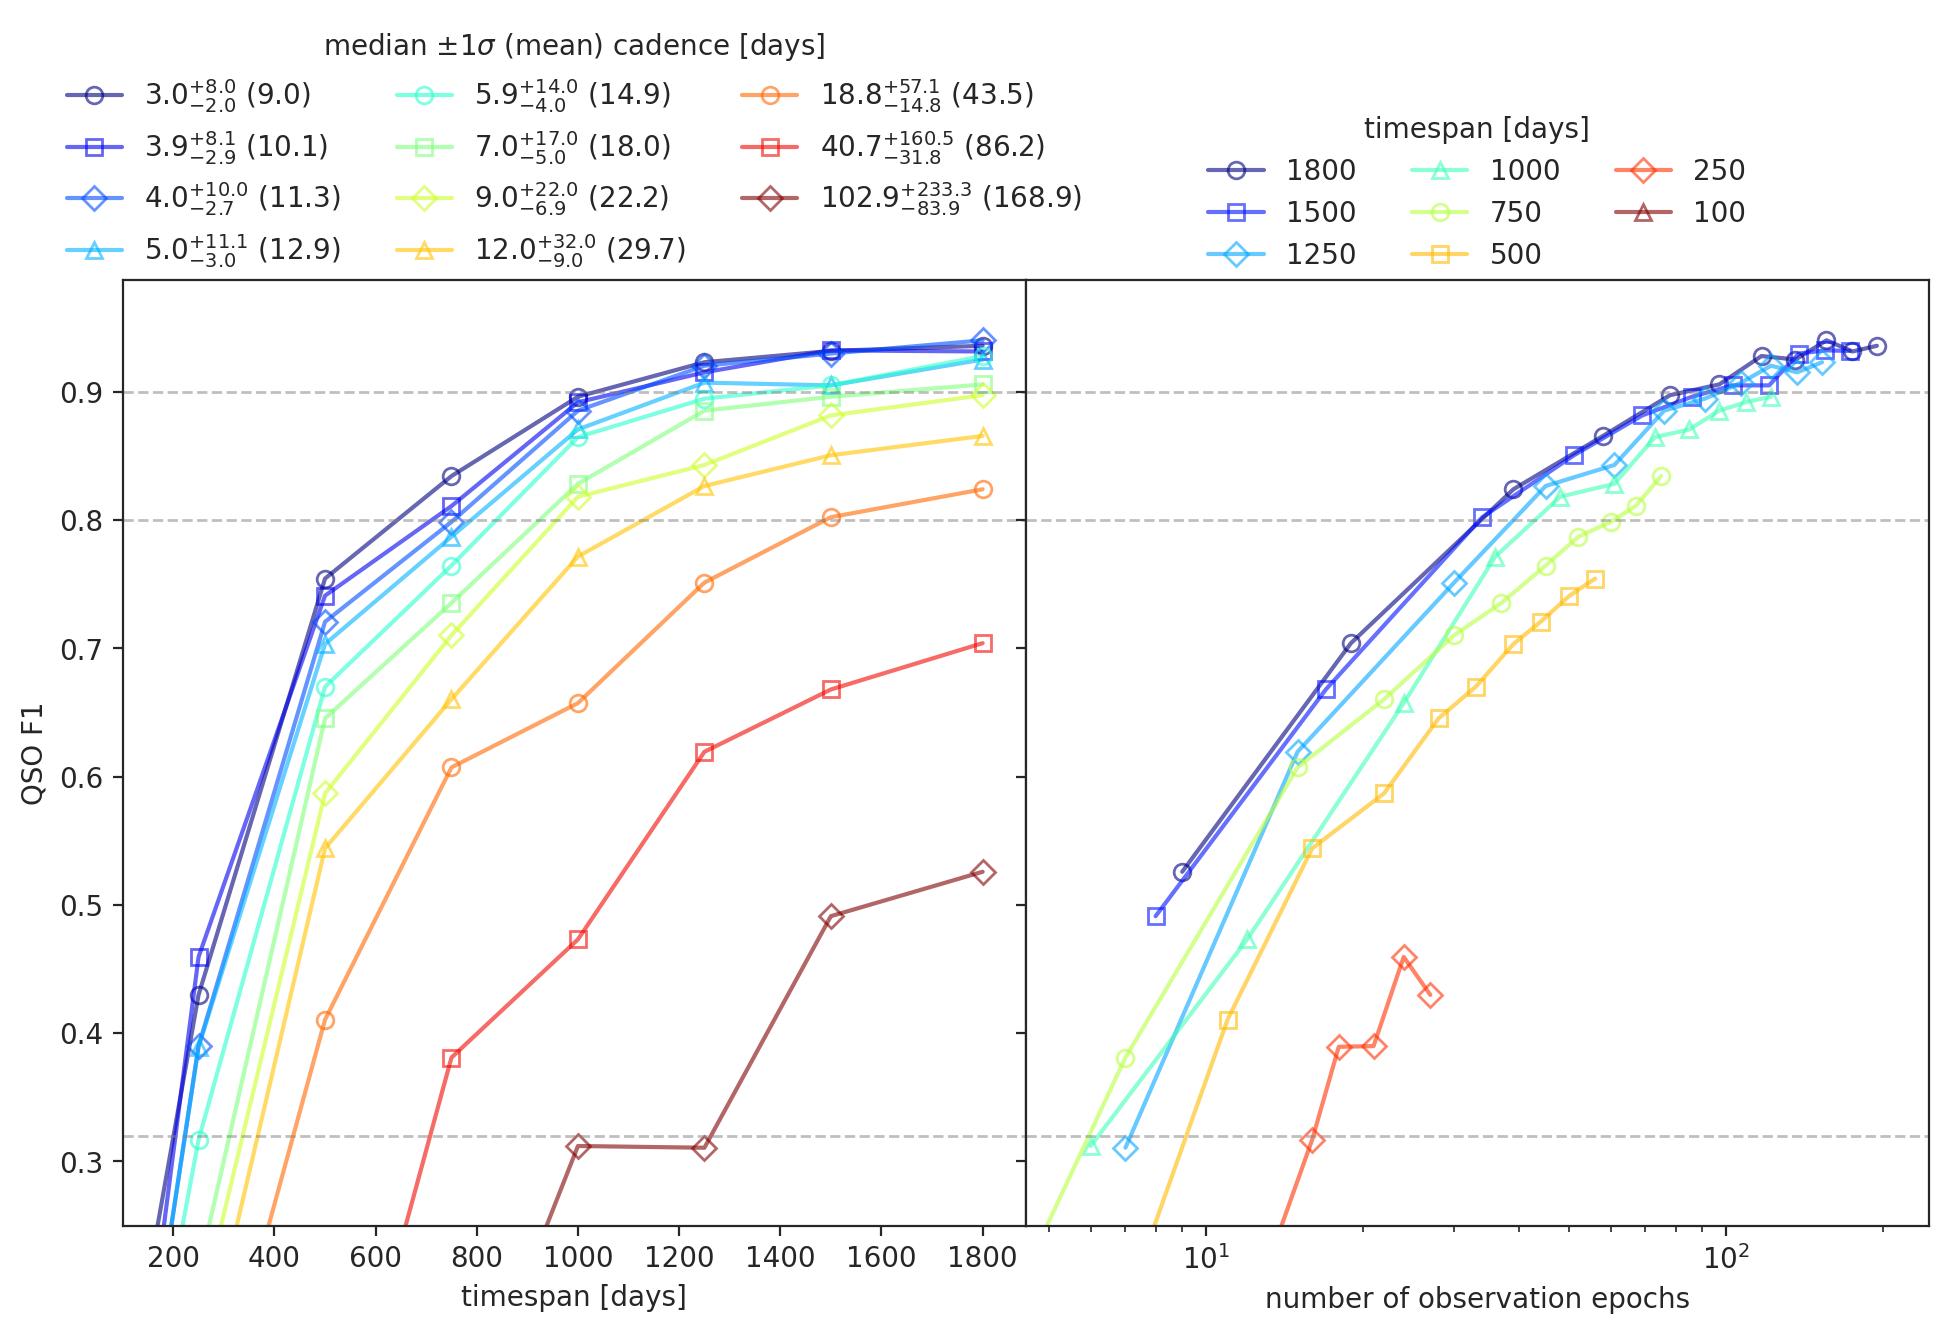

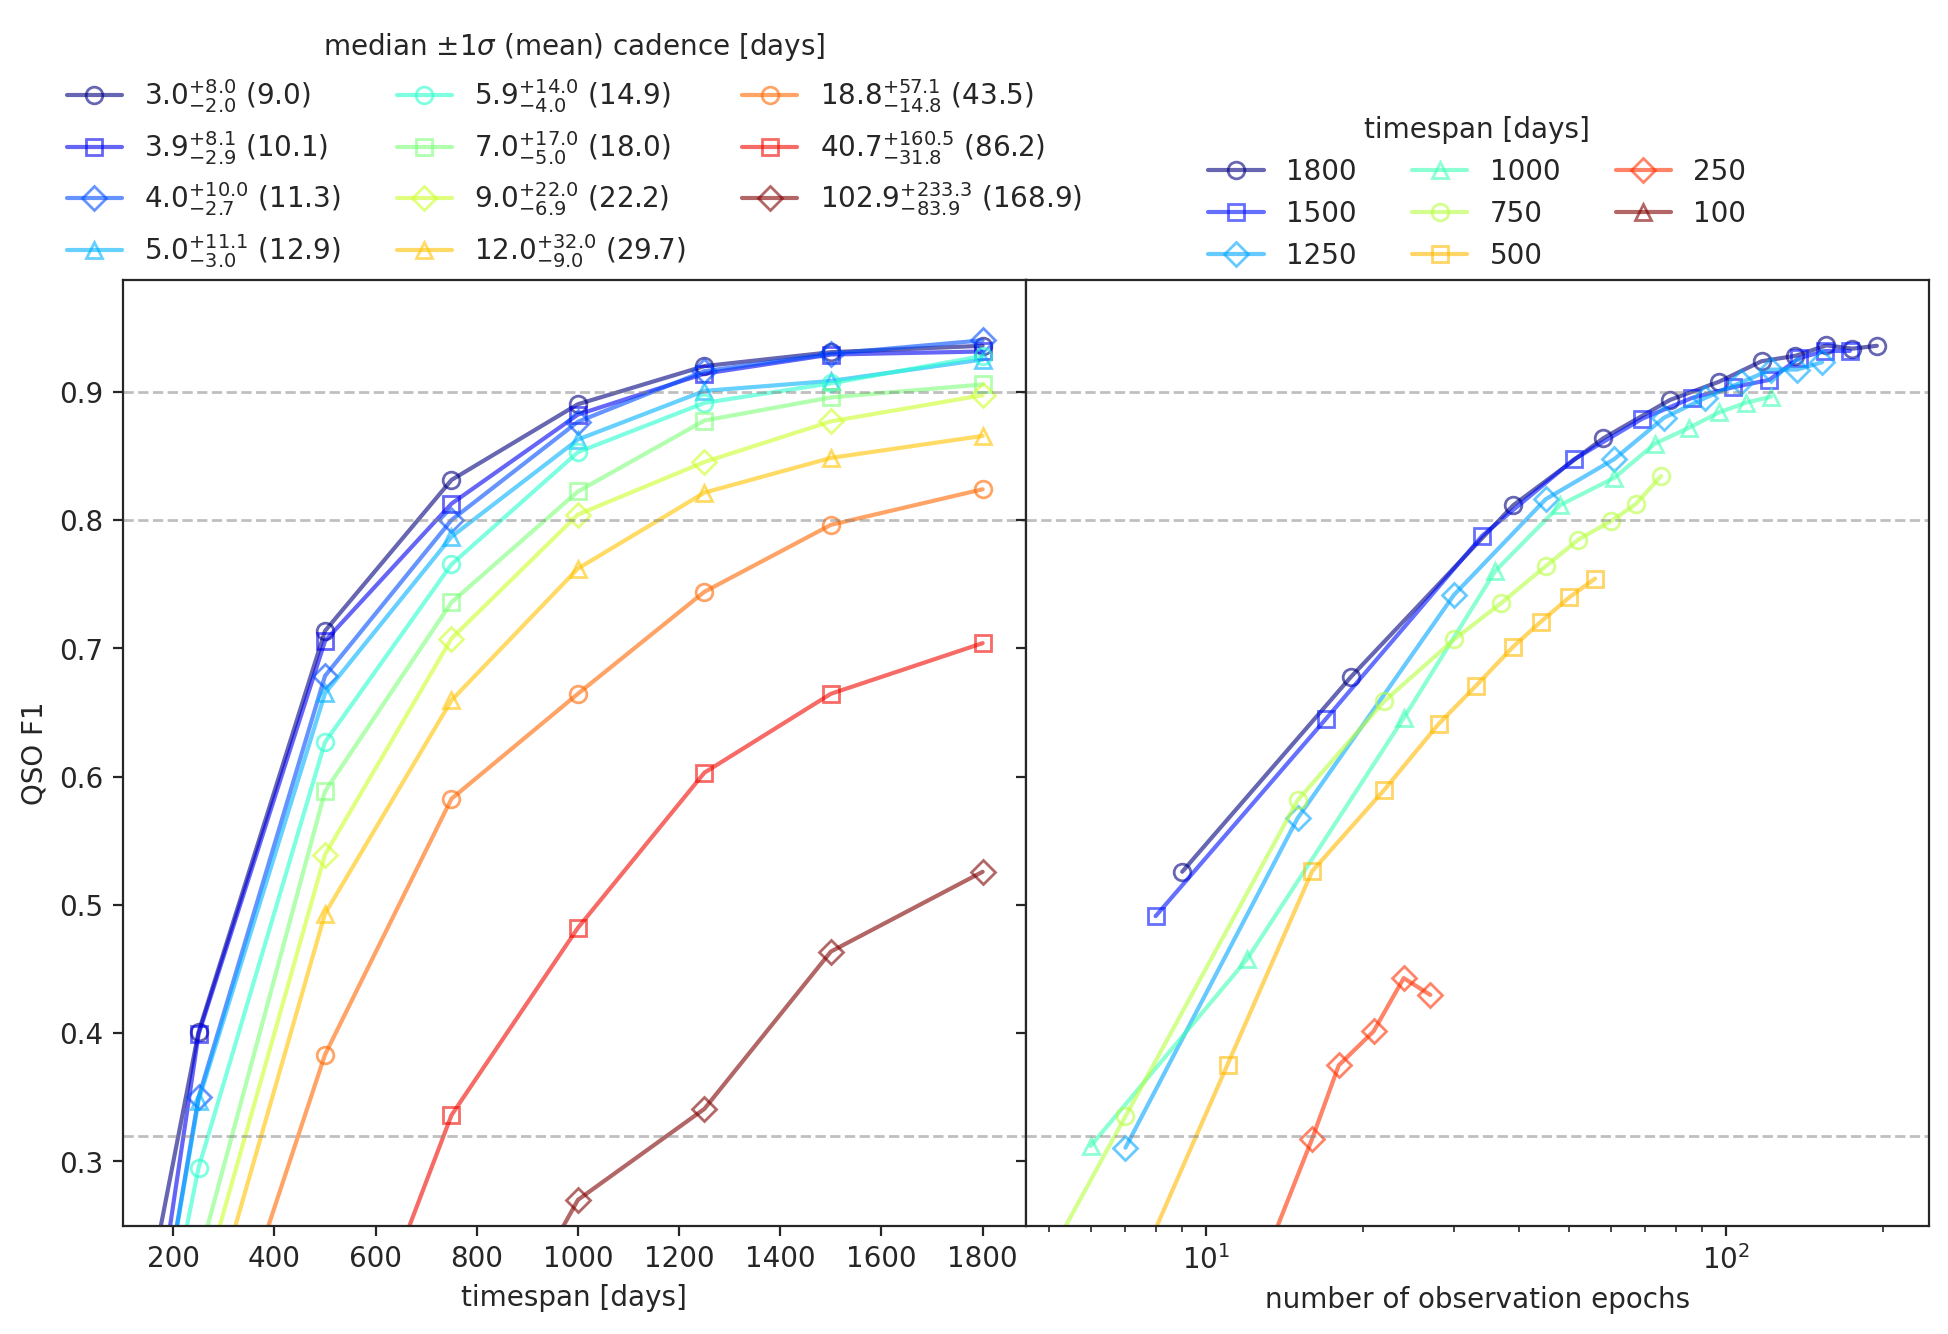

In [83]:
# Define the x and hue of plots
to_plot = [
    ('timespan', 'median_cadence'),
    # ('mean_cadence', 'timespan'),
    ('n_obs', 'timespan'),
]

for with_smoothing in [False, True]:
    fig = plt.figure(figsize=(10, 7))
    gs = fig.add_gridspec(1, 2, wspace=0)
    axs = gs.subplots(sharey=True)

    for i, (x, hue) in enumerate(to_plot):
        # Remove unnecessary zero scores
        df_plot = df
        if not is_smooth:
            if hue == 'median_cadence':
                df_plot = df[~((df['timespan'] == 100) & (df['p_obs'] <= 10)) &
                             ~((df['timespan'] == 250) & (df['p_obs'] <= 5))]
            elif hue == 'timespan':
                df_plot = df[~((df['timespan'] == 100) & (df['p_obs'] <= 80)) &
                             ~((df['timespan'] == 250) & (df['p_obs'] <= 5))]

        hue_vals = df[hue].unique()
        colors = plt.cm.jet(np.linspace(0, 1, len(hue_vals)))
        for j, hue_val in enumerate(hue_vals):
            df_line = df_plot.loc[df_plot[hue] == hue_val]
            label = hue_val
            if x == 'timespan' and hue == 'median_cadence':
                label = '${:.1f}^{{+{:.1f}}}_{{-{:.1f}}}$ $({:.1f})$'.format(
                    hue_val,
                    df_line['plus_sigma_cadence'].iloc[0],
                    df_line['minus_sigma_cadence'].iloc[0],
                    df_line['mean_cadence'].iloc[0],
                )

            # Line with smoothing
            y_vals = df_line['QSO F1'].to_list()
            y_vals_smooth = copy(y_vals)
            if with_smoothing:                
                for k in range(1, len(y_vals) - 1):
                    intervals = np.diff(df_line[x].to_list()[k-1:k+2])
                    weight_scales = -250 / intervals
                    middle_weight = 2 * sum(weight_scales)
                    weights = [weight_scales[0], middle_weight, weight_scales[1]]
                    y_vals_smooth[k] = np.average(y_vals[k-1:k+2], weights=weights)

            # Plot points and lines
            markers = ['o', 's', 'D', '^']
            marker = markers[j % len(markers)] + '-'
            # Bootstrap error is too small between 0.001 - 0.004
            axs[i].plot(df_line[x], y_vals_smooth, marker, color=colors[j], label=label, alpha=0.6, fillstyle='none')

        axs[i].axhline(y=0.9, color='grey', alpha=0.5, linestyle='--', linewidth=1)
        axs[i].axhline(y=0.8, color='grey', alpha=0.5, linestyle='--', linewidth=1)
        axs[i].axhline(y=0.32, color='grey', alpha=0.5, linestyle='--', linewidth=1)

        legend_title = pretty_print(hue)
        if hue == 'median_cadence':
            legend_title = 'median $\pm 1\sigma$ (mean) cadence [days]'
            axs[i].legend(title=legend_title, loc='upper center', bbox_to_anchor=(0.5, 1.29), ncol=3, frameon=False)
        elif hue == 'timespan':
            axs[i].legend(title=legend_title, loc='upper center', bbox_to_anchor=(0.5, 1.20), ncol=3, frameon=False)            

        axs[i].set_xlabel(pretty_print(x))
        if i == 0:
             axs[i].set_ylabel('QSO F1')
        if hue == 'timespan':
            axs[i].set_xscale('log')
        if x == 'timespan':
            axs[i].set_xlim((100, None))
        elif x == 'n_obs':
            axs[i].set_xlim((4.5, None))
        axs[i].set_ylim((0.25, None))
    
    for ax in axs:
        ax.label_outer()
        
    plt.tight_layout()
    plt.show()

In [24]:
df.loc[df['timespan'] == 1800]

,timespan,p_obs,n_obs,QSO F1,mean_cadence,std_cadence,median_cadence,minus_sigma_cadence,plus_sigma_cadence
65,1800,100,195,0.935923,9.033823,21.788162,3.040080,1.996340,7.954019
75,1800,90,175,0.931485,10.052807,23.340811,3.942700,2.872870,8.121735
74,1800,80,156,0.940182,11.258129,25.123897,4.013380,2.668320,9.987200
73,1800,70,136,0.925209,12.885684,27.447198,4.960270,3.028620,11.103778
72,1800,60,117,0.927936,14.940314,30.268418,5.942030,3.974550,13.952650
70,1800,50,97,0.905783,17.953983,34.212916,6.974740,4.975120,17.021045
69,1800,40,78,0.897392,22.222950,39.522842,8.956515,6.910695,21.976602
68,1800,30,58,0.865657,29.659942,48.132830,12.002433,9.010623,31.995263
67,1800,20,39,0.824046,43.544848,62.822451,18.828700,14.808380,57.057977
66,1800,10,19,0.704081,86.204049,101.731569,40.741855,31.819940,160.531597


In [25]:
df.loc[df['timespan'] == 1000]

,timespan,p_obs,n_obs,QSO F1,mean_cadence,std_cadence,median_cadence,minus_sigma_cadence,plus_sigma_cadence
0,1000,100,122,0.896224,9.033823,NaN,3.040080,NaN,NaN
10,1000,90,109,0.891889,10.052807,NaN,3.942700,NaN,NaN
9,1000,80,97,0.885340,11.258129,NaN,4.013380,NaN,NaN
8,1000,70,85,0.870718,12.885684,NaN,4.960270,NaN,NaN
7,1000,60,73,0.864708,14.940314,NaN,5.942030,NaN,NaN
5,1000,50,61,0.828334,17.953983,NaN,6.974740,NaN,NaN
4,1000,40,48,0.818251,22.222950,NaN,8.956515,NaN,NaN
3,1000,30,36,0.771596,29.659942,NaN,12.002433,NaN,NaN
2,1000,20,24,0.657337,43.544848,NaN,18.828700,NaN,NaN
1,1000,10,12,0.473114,86.204049,NaN,40.741855,NaN,NaN


In [ ]:
# Display a latex version of the df for the paper
df_1800 = df.loc[df['timespan'] == 1800]
df_paper = pd.DataFrame()
df_paper['frac_n_obs'] = df_1800['p_obs']
df_paper['cadence_mean'] = df_1800.apply(lambda x: '${:.1f} \pm {:.1f}$'.format(x['mean_cadence'], x['std_cadence']), axis=1)
df_paper['cadence_median'] = df_1800.apply(lambda x: '${:.1f}^{{+{:.1f}}}_{{-{:.1f}}}$'.format(x['median_cadence'], x['plus_sigma_cadence'], x['minus_sigma_cadence']), axis=1)

print(df_paper.to_latex(escape=False, na_rep='', float_format='%.2f', index=False))